In [1]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_algorithms import optimizers as opt
from qiskit_algorithms.utils import algorithm_globals as ag
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.utils import algorithm_globals

from pandas import read_csv as rcsv
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix as cfmat, ConfusionMatrixDisplay as cfmat_d

import json
from time import time as t
from datetime import datetime as dt
from matplotlib import pyplot as plt
from numpy import ndarray

### Experiment Design
1. number of PCs: [2]
2. quantum circuits: [RealAmplitudes, EfficientSU2]
3. optimizers: [COBYLA, CG]

In [2]:
# load dataset
my_dataset = rcsv("datasets/20231022_sudden_cardiac_arrest_ftr.csv")

# feature selection (manual)
selected_ftr = ['mean_nni', 'rmssd', 'mean_hr', 'triangular_index', \
                'total_power', 'csi', 'cvi', 'entropy']

# PCA for feature reduction
N_COMPONENTS = 3
X = my_dataset[selected_ftr].to_numpy()

if N_COMPONENTS != len(selected_ftr):
    X = PCA(n_components=N_COMPONENTS).fit_transform(X)
    
y = my_dataset.label.to_numpy()

# split dataset
X_train, X_test, y_train, y_test = tts(X, y, test_size=.25, random_state=43)

# scale the data
scaler = mms()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [5]:
my_dataset.label.value_counts()

1    376
0    360
Name: label, dtype: int64

Feature Map: 


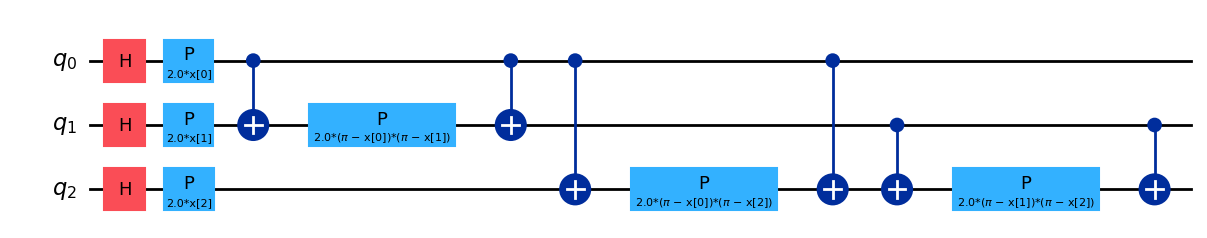

In [3]:
num_features = X_train_scaled.shape[1]
print("Feature Map: ")
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20, style="iqp")

Ansatz: 


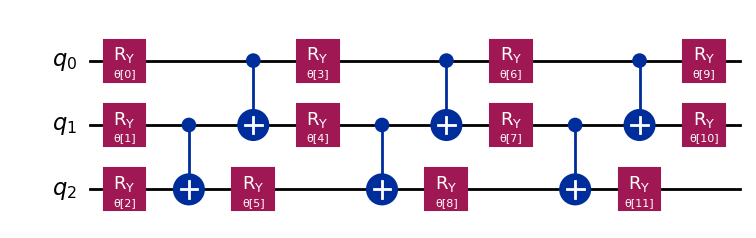

In [4]:
print("Ansatz: ")
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20, style="iqp")

In [5]:
def evaluate(
    y_pred : ndarray,
    y_test : ndarray,
    fig_title : str,
    save_fig_fname : str = None,
    *args, **kwargs
) -> dict:
    
    start_time = t()
    
    # offline metrics
    tn, fp, fn, tp = cfmat(y_pred, y_test).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    
    # plot Confusion Matrix
    print("Confusion Matrix: ")
    cm = cfmat(y_test, y_pred, labels=[0, 1])
    disp = cfmat_d(
        confusion_matrix=cm,
        display_labels=["Malignant\nVentricular\nEctopy", "Normal\nSinus\nRhythm"]
    )
    
    disp.plot(cmap=plt.cm.Purples)
    plt.title(fig_title)
    plt.savefig(fname=save_fig_fname, dpi=200, bbox_inches="tight", format="png")
    plt.show()
    
    return {
        "accuracy" : float(accuracy_score(y_pred, y_test)),
        "true_pos" : int(tp),
        "true_neg" : int(tn),
        "false_pos" : int(fp),
        "false_neg" : int(fn),
        "recall" : float(recall),
        "precision" : float(precision),
        "f1_score" : float(f1_score),
        "false_pos_rate" : fpr.tolist(),
        "true_pos_rate" : tpr.tolist(),
        "auc_roc_score" : float(auc(fpr, tpr)),
        "exc_time" : round(t()-start_time, 3),
        "created_at" : dt.now().strftime("%Y-%m-%d %X")
    }

In [8]:
def callback_graph(weights, obj_func_eval):
    print(" - Loss: {:.5f}".format(obj_func_eval))
    objective_func_vals.append(obj_func_eval)
    
    # plt.title("Objective function value against iteration")
    # plt.xlabel("Iteration")
    # plt.ylabel("Objective function value")
    # plt.plot(range(len(objective_func_vals)), objective_func_vals)
    # plt.show()

Feature Map: 
Ansatz: RealAmplitudes
Optimizer: CG
 - Loss: 1.05735
 - Loss: 0.99189
 - Loss: 0.80136
 - Loss: 0.70760
 - Loss: 0.69029
 - Loss: 0.65654
 - Loss: 0.64244
 - Loss: 0.58984
 - Loss: 0.58112
 - Loss: 0.55299
 - Loss: 0.52429
 - Loss: 0.50887
 - Loss: 0.50278
 - Loss: 0.49428
 - Loss: 0.49128
 - Loss: 0.48536
 - Loss: 0.48522
 - Loss: 0.48502
 - Loss: 0.48491
 - Loss: 0.48451
 - Loss: 0.48350
 - Loss: 0.48304
 - Loss: 0.48128
 - Loss: 0.47650
 - Loss: 0.47075
 - Loss: 0.46914
 - Loss: 0.46925
 - Loss: 0.46155
 - Loss: 0.45400
 - Loss: 0.45238
 - Loss: 0.44733
 - Loss: 0.44443
 - Loss: 0.44389
 - Loss: 0.44210
 - Loss: 0.44036
 - Loss: 0.43996
 - Loss: 0.43935
 - Loss: 0.43922
 - Loss: 0.43875
 - Loss: 0.43810
         Current function value: 0.438097
         Iterations: 15
         Function evaluations: 40
         Gradient evaluations: 40
Training time: 3400.900 s.
Quantum VQC - Train acc: 0.953
Quantum VQC - Test acc: 0.728
Confusion Matrix: 


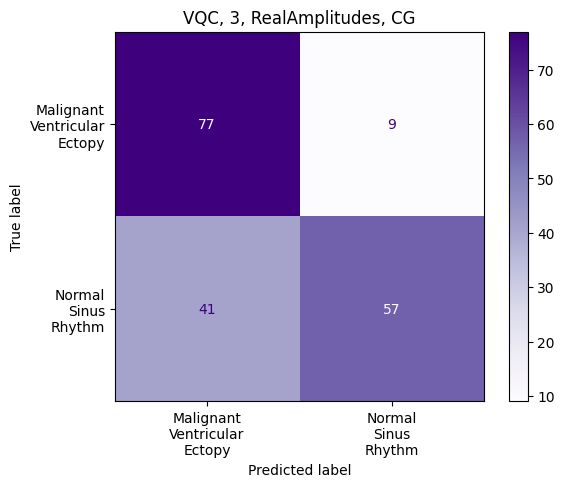

Ansatz: EfficientSU2
Optimizer: CG
 - Loss: 0.78062
 - Loss: 0.67761
 - Loss: 0.57205
 - Loss: 0.53351
 - Loss: 0.48061
 - Loss: 0.46584
 - Loss: 0.44955
 - Loss: 0.44669
 - Loss: 0.44376
 - Loss: 0.44108
 - Loss: 0.43494
 - Loss: 0.43182
 - Loss: 0.42706
 - Loss: 0.42600
 - Loss: 0.42297
 - Loss: 0.42173
 - Loss: 0.42012
 - Loss: 0.41540
 - Loss: 0.41527
 - Loss: 0.41344
 - Loss: 0.41140
 - Loss: 0.40917
 - Loss: 0.40423
 - Loss: 0.40412
 - Loss: 0.40418
 - Loss: 0.40407
 - Loss: 0.40409
 - Loss: 0.40405
 - Loss: 0.40406
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40405
 - Loss: 0.40412
 - Loss: 0.40406
 - Loss: 0.40409
 - Loss: 0.40405
 - Loss: 0.40406
 - Loss: 0.40405
 - Loss: 0.40

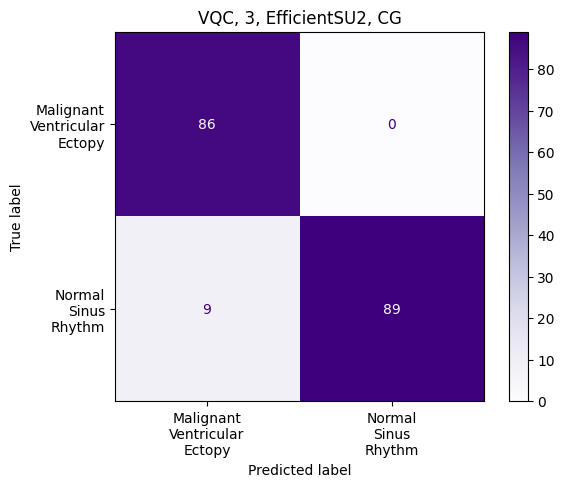

In [7]:
num_features = X_train_scaled.shape[1]

# FEATURE MAP
print("Feature Map: ")
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(
    output="mpl", fold=20, style="iqp",
    filename="pics/feature_map_{}pc.png".format(N_COMPONENTS)
)

# ANSATZ
real_amplitude = RealAmplitudes(num_qubits=num_features, reps=3)
efficient_su2 = EfficientSU2(num_qubits=num_features, reps=3)

for ansatz in [real_amplitude, efficient_su2]:
    print("Ansatz: {}".format(ansatz._base_name))
    ansatz.decompose().draw(
        output="mpl", fold=20, style="iqp",
        filename="pics/ansatz_{}pc_{}.png".format(N_COMPONENTS, ansatz._base_name)
    )

    # MODELING (with different OPTIMIZERS)
    ag.random_seed = 0
    max_epoch = 15
    optimizer_list = [opt.CG(maxiter=max_epoch, disp=True)] # , opt.COBYLA(maxiter=max_epoch)

    for optimizer in optimizer_list:
        method_name = optimizer._method.upper()
        print("Optimizer: {}".format(method_name))

        sampler = Sampler()
        vqc = VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=callback_graph,
        )

        # clear objective value history
        objective_func_vals = []

        start = t()
        vqc.fit(X_train_scaled, y_train)
        elapsed = t() - start

        print("Training time: {:.3f} s.".format(elapsed))

        # save to JSON
        return_dict = {
            "optimizer" : method_name,
            "loss" : objective_func_vals,
            "exc_time" : round(elapsed, 3),
            "created_at" : dt.now().strftime("%Y-%m-%d %X")
        }

        # save training log
        trn_save_fname = "model/train/{}pc_{}_{}.json".format(N_COMPONENTS, ansatz._base_name, method_name)
        with open(trn_save_fname, "w") as outfile: 
            json.dump(return_dict, outfile)

        # record train and test accuracies
        train_score = vqc.score(X_train_scaled, y_train)
        print("Quantum VQC - Train acc: {:.3f}".format(train_score))
        test_score = vqc.score(X_test_scaled, y_test)
        print("Quantum VQC - Test acc: {:.3f}".format(test_score))

        # confusion matrix for evaluation
        y_predict = vqc.predict(X_test_scaled)
        cfmatrix_fig_title = "VQC, {}, {}, {}".format(N_COMPONENTS, ansatz._base_name, method_name)
        cfmatrix_savefig_fname = "pics/cfmat_{}pc_{}_{}.png".format(N_COMPONENTS, ansatz._base_name, method_name)
        ev = evaluate(y_predict, y_test, fig_title=cfmatrix_fig_title, save_fig_fname=cfmatrix_savefig_fname)

        # add "train_acc"
        eval_list = ev.copy()
        pos = list(eval_list.keys()).index('accuracy')
        del eval_list["accuracy"]

        items = list(eval_list.items())
        items.insert(pos, ("train_acc", train_score))
        items.insert(pos+1, ("test_acc", test_score))
        eval_ = dict(items)

        # save evaluation log
        tst_save_fname = "model/test/{}pc_{}_{}.json".format(N_COMPONENTS, ansatz._base_name, method_name)
        with open(tst_save_fname, "w") as outfile: 
            json.dump(eval_, outfile)

### Draw VQC Neural Network circuits

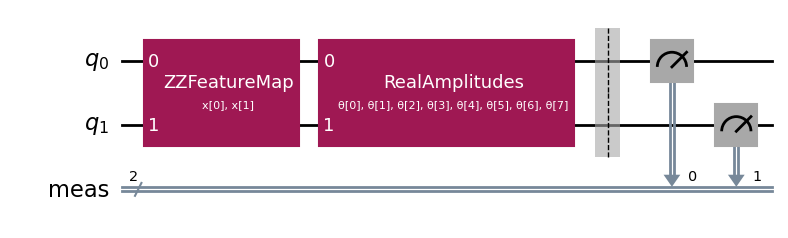

In [13]:
num_features = 2
max_epoch = 1

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
real_amplitude = RealAmplitudes(num_qubits=num_features, reps=3)
efficient_su2 = EfficientSU2(num_qubits=num_features, reps=3)

VQCs = []
for ansatz in [real_amplitude, efficient_su2]:

    optimizer_list = [opt.CG(maxiter=max_epoch, disp=True), opt.COBYLA(maxiter=max_epoch)]
    for optimizer in optimizer_list:
        sampler = Sampler()
        vqc = VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=callback_graph,
        )
        VQCs.append(vqc)

VQCs[0].neural_network.circuit.draw(output="mpl", style="iqp", filename="pics/vqc_neuralnet_circuit_{}pc.png".format(num_features))

### Plot training losses

In [3]:
import os, json
from matplotlib import pyplot as plt

In [4]:
TRAIN_LOG_PATH = "model/train/"
TRAIN_LOG_FNAME_COBYLA = [TRAIN_LOG_PATH + p for p in os.listdir(TRAIN_LOG_PATH) if p.endswith("COBYLA.json")]
TRAIN_LOG_FNAME_CG = [TRAIN_LOG_PATH + p for p in os.listdir(TRAIN_LOG_PATH) if p.endswith("CG.json")]

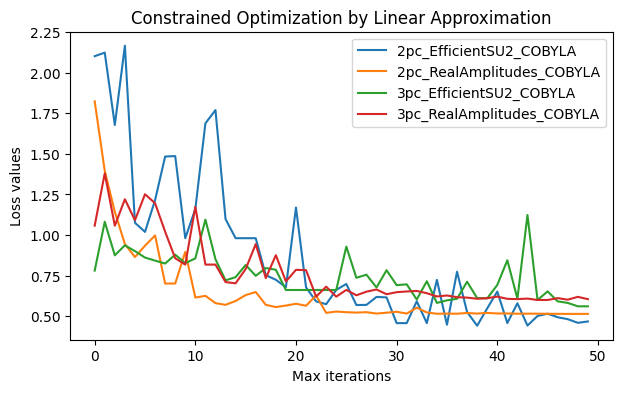

In [5]:
plt.figure(figsize=(7, 4))
for cb in TRAIN_LOG_FNAME_COBYLA:
    with open(cb, "r") as f:
        tr_log_cb = json.load(f)
        label_cb = cb.split(".json")[0].split("/")[-1]
    plt.plot(tr_log_cb["loss"], label=label_cb)

plt.title("Constrained Optimization by Linear Approximation")
plt.xlabel("Max iterations")
plt.ylabel("Loss values")
plt.legend(loc='best')
plt.savefig(fname="pics/training_loss_COBYLA.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

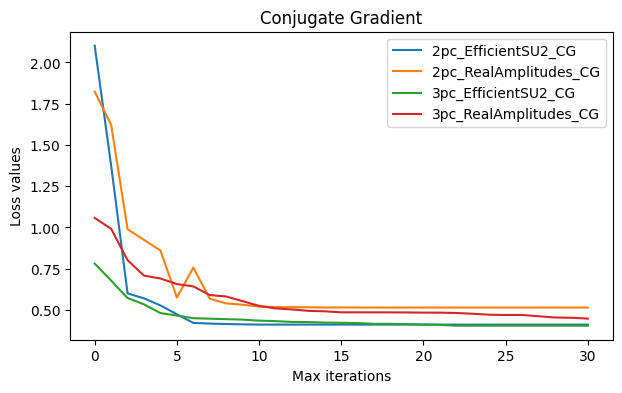

In [6]:
CG_LOSSES = []
CG_LABELS = []
for cg in TRAIN_LOG_FNAME_CG:
    with open(cg, "r") as f:
        cg_log = json.load(f)
        CG_LOSSES.append(cg_log["loss"])
        CG_LABELS.append(cg.split(".json")[0].split("/")[-1])

# truncate all CG losses based on the shortest one
min_cg_len = len(min(CG_LOSSES, key=len))
plt.figure(figsize=(7, 4))
for label_cg, t in zip(CG_LABELS, CG_LOSSES):
    plt.plot(t[:min_cg_len], label=label_cg)
    
plt.title("Conjugate Gradient")
plt.xlabel("Max iterations")
plt.ylabel("Loss values")
plt.legend(loc='best')
plt.savefig(fname="pics/training_loss_CG.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

### Put testing results on DataFrame

In [7]:
from pandas import DataFrame as df

In [50]:
TEST_LOG_PATH = "model/test/"
TEST_LOG_PATH = [TEST_LOG_PATH + p for p in os.listdir(TEST_LOG_PATH) if p.endswith(".json")]
TEST_LOG_PATH.sort(key=lambda x: x.split(".json")[0].split("/")[-1].split("_")[-1], reverse=True)

In [59]:
TEST_RESULTS = []
for tst in TEST_LOG_PATH:
    with open(tst, "r") as ff:
        excl_list = ["false_pos_rate", "true_pos_rate", "created_at", \
                     "true_pos", "true_neg", "false_pos", "false_neg", "exc_time"]
        tst_load_file = json.load(ff)
        
        test_log = dict()
        test_log["exp"] = tst.split(".json")[0].split("/")[-1]
        test_log.update({k : v for k, v in tst_load_file.items() if k not in excl_list})
        TEST_RESULTS.append(test_log)

In [67]:
TRAIN_EXC_TIME = []
for trn in TRAIN_LOG_FNAME_COBYLA + TRAIN_LOG_FNAME_CG:
    with open(trn, "r") as tfile:
        excl_list = ["optimizer", "loss", "created_at"]
        tr_load_file = json.load(tfile)
        
        trn_log = dict()
        trn_log["exp"] = trn.split(".json")[0].split("/")[-1]
        trn_log.update({k : v for k, v in tr_load_file.items() if k not in excl_list})
        
        # change seconds to HH:MM:SS
        m, s = divmod(trn_log["exc_time"], 60)
        h, m = divmod(m, 60)
        trn_log["exc_time"] = "{}h, {}m, {:.3f}s".format(h, m, s)
        
        TRAIN_EXC_TIME.append(trn_log)

In [68]:
df(TEST_RESULTS).merge(df(TRAIN_EXC_TIME), on="exp")

,exp,train_acc,test_acc,recall,precision,f1_score,auc_roc_score,exc_time
0,2pc_EfficientSU2_COBYLA,0.936594,0.559783,0.947368,0.183673,0.307692,0.586023,"0.0h, 6.0m, 58.655s"
1,2pc_RealAmplitudes_COBYLA,0.947464,0.619565,1.000000,0.285714,0.444444,0.642857,"0.0h, 4.0m, 11.275s"
2,3pc_EfficientSU2_COBYLA,0.927536,0.885870,0.932584,0.846939,0.887701,0.888586,"0.0h, 11.0m, 15.245s"
3,3pc_RealAmplitudes_COBYLA,0.927536,0.913043,0.945652,0.887755,0.915789,0.914808,"0.0h, 9.0m, 5.264s"
4,2pc_EfficientSU2_CG,0.961957,0.554348,0.833333,0.204082,0.327869,0.578785,"0.0h, 23.0m, 45.680s"
5,2pc_RealAmplitudes_CG,0.945652,0.625000,1.000000,0.295918,0.456693,0.647959,"0.0h, 19.0m, 5.657s"
6,3pc_EfficientSU2_CG,0.951087,0.951087,1.000000,0.908163,0.951872,0.954082,"2.0h, 46.0m, 23.706s"
7,3pc_RealAmplitudes_CG,0.952899,0.728261,0.863636,0.581633,0.695122,0.738491,"0.0h, 56.0m, 40.900s"
